# Module 2 project
*Laura Lewis, March 2019*

Overall goal - use the Northwind database to extract useful insights for the company. Northwind database is... Microsoft... etc... Specifically, asking four questions:

1. Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

2. Do discounts result in customers spending more or less on their orders? If so, at what level(s) of discount, and do discounts earn more than they cost?

3. Does the average amount spent per order vary between customers from different regions?

4. Do customers order more products on particular days of the week?

***

## Question 1: Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

### Obtaining and scrubbing the data

In this section, the data required to answer the question will be imported using SQLAlchemy. Then the dataset will be cleaned so that exploratory analysis and statistical tests are able to be conducted in the following section.

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import inspect
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

The database schema is illustrated below. This was used to determine what data was required and how to extract it.

![title](Northwind_ERD.png)

In [2]:
# Creating an engine and connecting to a database with SQLAlchemy
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()
con = engine.connect()

2019-03-08 10:34:57,841 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-03-08 10:34:57,850 INFO sqlalchemy.engine.base.Engine ()
2019-03-08 10:34:57,852 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-03-08 10:34:57,853 INFO sqlalchemy.engine.base.Engine ()


In [3]:
# Getting the table names
inspector = inspect(engine)
inspector.get_table_names()

2019-03-08 10:34:58,535 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-03-08 10:34:58,537 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

In this query, we want to extract the quantity of products ordered and the discount level for each order, so we need to group by OrderId. There is also a chance that different discount levels have been applied within the same order, so we also want to group by Discount so that each discount level for each order can be seen (otherwise the query may simply select and display the first Discount value that appears for that order). OrderId refers to the overall ID of the whole order (it is a foreign key, linking to the primary key of the Orders table), whereas Id in the OrderDetails table refers to a sub-order, where there is a separate Id for each individual product within the overall order. This is why we group by OrderId rather than Id.

In [117]:
# Extracting the dataset for question 1 as a pandas dataframe
df1 = pd.read_sql_query("""SELECT OrderId, SUM(Quantity) as Total_Quantity, Discount
FROM OrderDetail
GROUP BY OrderId, Discount""", engine)
df1.head()

2019-03-08 14:02:21,999 INFO sqlalchemy.engine.base.Engine SELECT OrderId, SUM(Quantity) as Total_Quantity, Discount
FROM OrderDetail
GROUP BY OrderId, Discount
2019-03-08 14:02:22,000 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Total_Quantity,Discount
0,10248,27,0.00
1,10249,49,0.00
2,10250,10,0.00
3,10250,50,0.15
4,10251,20,0.00


In [118]:
# Number of unique OrderIds in the dataset
df1.OrderId.nunique()

830

In [119]:
# Total number of rows in the dataset
len(df1)

1000

There are 830 orders in the dataset, but 1000 rows. Because orders are grouped by discount as well as by order, this means that some orders contain products with different discounts applied (e.g. order 10250 contains 10 items with no discount, and 50 items with a 15% discount). There are multiple ways of dealing with this, e.g. in the case of order 10250 this could be counted as two separate orders, or the discount applied to the majority of items could be used. However, because the purpose of this analysis is to later be able to conduct statistical tests, it is preferable here to drop the rows that could confuse the analysis (e.g. because products are counted as being from separate orders when they were actually placed by the same person at the same time in the same order).

In [7]:
# Dropping all rows containing duplicates of OrderId
df1.drop_duplicates(subset=['OrderId'], keep=False, inplace=True)

In [8]:
# Checking the new length of the dataset and whether duplicates have been dropped
print(len(df1))
print(df1.OrderId.nunique() == len(df1))

667
True


The question refers to orders either with or without a discount. An additional column will be added to bin discount levels into orders where the discount is 0 (no discount) and orders with a discount greater than 0 (has a discount).

In [10]:
# Binning discount levels into 1 (discount) and 0 (no discount)
df1['Discount_bin'] = df1['Discount'].apply(lambda x: 1 if x > 0 else 0)

The database can now be inspected for any further necessary cleaning.

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 0 to 990
Data columns (total 3 columns):
OrderId           667 non-null int64
Total_Quantity    667 non-null int64
Discount          667 non-null float64
dtypes: float64(1), int64(2)
memory usage: 20.8 KB


There are no null values, so there is no need to replace any values.

### Exploring the data and answering the question

In this section, the dataset will be explored and the question will be answered by using statistical tests.

#### Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?

To answer the first part of this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same with and without a discount

**H<sub>a</sub>**: the average number of products ordered with a discount is either higher or lower than orders without a discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [11]:
# Inspecting the summary statistics
df1.describe()

,OrderId,Total_Quantity,Discount,Discount_bin
count,667.000000,667.000000,667.000000,667.000000
mean,10666.509745,56.608696,0.046027,0.325337
std,238.826223,48.787196,0.078193,0.468852
min,10248.000000,1.000000,0.000000,0.000000
25%,10459.000000,22.000000,0.000000,0.000000
50%,10671.000000,42.000000,0.000000,0.000000
75%,10873.500000,77.500000,0.050000,1.000000
max,11076.000000,346.000000,0.250000,1.000000


The graphs below show that discounts range from 5% off to 25% off. The vast majority of orders have no discount. However, the average number of items per order with any level of discount is higher than for orders with no discount, although this does not appear to be a consistently increasing pattern.

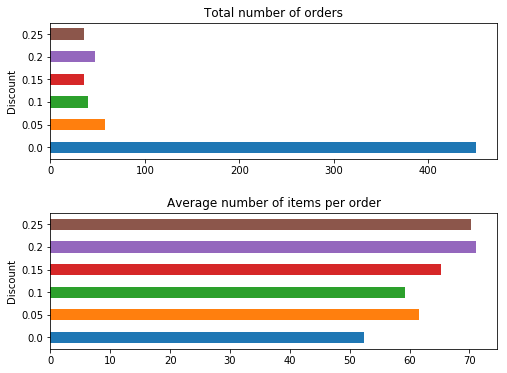

In [12]:
# Plotting the number of orders and average quantity of items per order for orders with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df1.groupby(['Discount'])['Total_Quantity'].count().plot(kind='barh', ax=ax1)
df1.groupby(['Discount'])['Total_Quantity'].mean().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average number of items per order')
ax1.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
ax2.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.4);

Another way of viewing this pattern, in a form that has more relevance for the particular null and alternate hypotheses under consideration, is to group orders by those with and without discounts. Although about twice as many orders have no discount compared to some level of discount, orders with a discount contain more items on average (65 items on average for orders with a discount, vs. 52 for orders with no discount). This lends support to the alternate hypothesis that the number of items per order is different for orders with discounts vs. no discounts. 

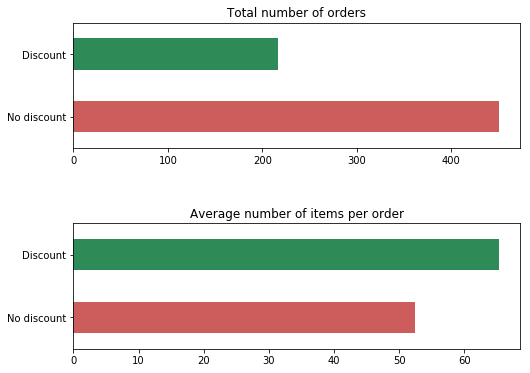

In [13]:
# Plotting the number of orders and average quantity of items per order for orders with and without discounts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df1.groupby(['Discount_bin'])['Total_Quantity'].count().plot(kind='barh', ax=ax1, color=['indianred', 'seagreen'])
df1.groupby(['Discount_bin'])['Total_Quantity'].mean().plot(kind='barh', ax=ax2, color=['indianred', 'seagreen'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Average number of items per order')
ax1.set_yticklabels(['No discount', 'Discount'])
ax2.set_yticklabels(['No discount', 'Discount'])
fig.subplots_adjust(hspace=0.6);

In [14]:
# Average number of items for orders with and without a discount
round(df1.groupby(['Discount_bin'])['Total_Quantity'].mean(),0)

Discount_bin
0    52.0
1    65.0
Name: Total_Quantity, dtype: float64

In order to answer this question with a degree of rigour, we must use statistical tests rather than just descriptive statistics. The correct hypothesis test needs to be chosen. In this case, a two-tailed t-test will be used. This is because the data is continuous, and because we are looking for either a decrease _or_ an increase in the number of products ordered.

A two-sample t-test assumes that the data is normally distributed, and that the samples have equal variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


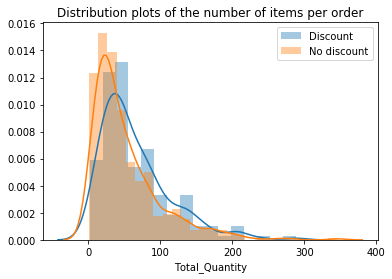

In [15]:
# Separating the dataset into orders with and without discounts, and assessing their distributions.
discount = df1[df1['Discount_bin'] == 1]
no_discount = df1[df1['Discount_bin'] == 0]
sns.distplot(discount.Total_Quantity, label='Discount')
sns.distplot(no_discount.Total_Quantity, label='No discount')
plt.title('Distribution plots of the number of items per order')
plt.legend();

The distribution plots above show that these assumptions hold true, and so a standard t-test can be used (as opposed to a Welch's t-test).

In [16]:
# Running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount.Total_Quantity, no_discount.Total_Quantity)

Ttest_indResult(statistic=3.1998176433298506, pvalue=0.0014405227760355727)

In [17]:
print("Average items per order for orders with no discounts: ", round(no_discount['Total_Quantity'].mean(),1))
print("Average items per order for orders with discounts: ", round(discount['Total_Quantity'].mean(),1))
print("Effect size: ", round(discount['Total_Quantity'].mean() - no_discount['Total_Quantity'].mean(),1))
print("Relative effect size (increase from no discount to discount): ", round(((discount['Total_Quantity'].mean() - no_discount['Total_Quantity'].mean())/no_discount['Total_Quantity'].mean())*100,1))

Average items per order for orders with no discounts:  52.4
Average items per order for orders with discounts:  65.3
Effect size:  12.8
Relative effect size (increase from no discount to discount):  24.4


The p-value is 0.001, which is less than our alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternative hypothesis. We can conclude that there is a statistically significant difference between the average number of items per order for orders with and without discounts, i.e. offering a discount does change (in this case increase) the number of items that a customer orders.

**On average:**

 - **There are 52 items per order with no discount, and 65 items per order with a discount**

 - **Orders with discounts contain 13 more items than orders with no discounts, which is a 24% increase.**

**However, these correlations do not necessarily imply causation, and so it is not possible to categorically state that offering a discount will necessarily increase the order size by 24%.**

The second part of the question asks at what level of discount the statistically significant effect occurs. To answer this part of this question, a new null and alternate hypothesis need to be created:

**H<sub>0</sub>**: the average number of products ordered is the same at different levels of discount

**H<sub>a</sub>**: the average number of products ordered is different between the different levels of discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

To answer this question, ANOVA will be used in order to assess the degree of variation between multiple samples, where each sample is a different level of discount.

In [18]:
# Fitting a model of Total_Quantity on Discount categories, and using statsmodels to compute an ANOVA table
lm = ols('Total_Quantity ~ C(Discount)', discount).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),4673.859574,4.0,0.486108,0.745935
Residual,509587.200334,212.0,NaN,NaN


In [19]:
# Summary of the model and its coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Quantity   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.4861
Date:                Thu, 07 Mar 2019   Prob (F-statistic):              0.746
Time:                        18:03:49   Log-Likelihood:                -1150.0
No. Observations:                 217   AIC:                             2310.
Df Residuals:                     212   BIC:                             2327.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              61.6379      6.438      9.575      0.000      48.948      74.328
C(Discount)[T.0.1]     -2.3879     10.077     -0.237      0.813     -22.251      17.475
C(Discount)[T.0.15]     3.5565     10.403      0.342      0.733     -16.949      24.062
C(Discount)[T.0.2]      9.4046      9.622      0.977      0.329      -9.563      28.372
C(Discount)[T.0.25]     8.6121     10.403      0.828      0.409     -11.894      29.118
==============================================================================
Omnibus:                       64.115   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.741
Skew:                           1.433   Prob(JB):                     2.47e-29
Kurtosis:                       5.520   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The ANOVA table above reveals that the p-value is 0.746, which is much higher than our alpha value of 0.05. Therefore we cannot reject the null hypothesis that there is no difference between the average number of items per order between different discount levels. The model summary table below that provides further evidence for this conclusion. The p-values for each pairwise comparison between the lowest level of discount (5%) and each other level of discount are all above the alpha value, indicating that no individual discount levels have a statistically significant effect. Additionally, the overall r/eta squared value for the model is negligible, confirming that the different discount levels do not explain the differences in the numbers of items per order in the different groups.

**To conclude, although having a discount has a statistically significant effect on the number of items per order, there is no statistically significant effect from increasing the level of discount. A preliminary conclusion is that the impact of offering any discount at all (e.g. only 5%) on an order is greater than the impact of increasing the level of discount offered (a conclusion supported by the literature on behavioural economics). So an actionable insight for the business could be to offer more low-value discounts, and reduce the number of higher-level discounts. However, further analysis would be needed in order to provide further evidence that the differences in the number of items per order was due primarily to discount level rather than other factors (e.g. by ruling out the impacts of other features, such as different orders containing different types of products).**

***

## Question 2: Do discounts result in customers spending more or less on their orders? If so, at what level(s) of discount, and do discounts earn more than they cost?

The analysis above suggested that offering discounts encourages customers to buy more items. However, there is also a very tangible cost to giving customers discounts. Therefore it is also worth investigating whether offering discounts also increases the average cost per order (because people are buying additional discounted products that they wouldn't have bought otherwise), or decreases the average cost per order (because people are buying a greater number of cheaper discounted products, but because of the discounts there is no net benefit to the company's bottom line).

### Obtaining and scrubbing the data

In this query, we want to extract for each order the number of each product ordered, the unit price and the discount level (for calculating the actual price paid), so we need to group by OrderId. There is also a chance that different discount levels have been applied within the same order, so we also want to group by Discount so that each discount level for each order can be seen (otherwise the query may simply select and display the first Discount value that appears for that order). OrderId refers to the overall ID of the whole order (it is a foreign key, linking to the primary key of the Orders table), whereas Id in the OrderDetails table refers to a sub-order, where there is a separate Id for each individual product within the overall order. This is why we group by OrderId rather than Id.

In [60]:
# Extracting the dataset for question 2 as a pandas dataframe
df2 = pd.read_sql_query("""SELECT OrderId, Quantity, UnitPrice, Discount
FROM OrderDetail
GROUP BY OrderId, Discount""", engine)
df2.head()

2019-03-08 10:58:24,806 INFO sqlalchemy.engine.base.Engine SELECT OrderId, Quantity, UnitPrice, Discount
FROM OrderDetail
GROUP BY OrderId, Discount
2019-03-08 10:58:24,807 INFO sqlalchemy.engine.base.Engine ()


,OrderId,Quantity,UnitPrice,Discount
0,10248,5,34.8,0.00
1,10249,40,42.4,0.00
2,10250,10,7.7,0.00
3,10250,15,16.8,0.15
4,10251,20,16.8,0.00


In [51]:
# Number of unique OrderIds in the dataset
df2.OrderId.nunique()

830

In [52]:
# Total number of rows in the dataset
len(df2)

1000

There are 830 orders in the dataset, but 1000 rows. Because orders are grouped by discount as well as by order, this means that some orders contain products with different discounts applied (e.g. order 10250 contains 10 items with no discount, and 50 items with a 15% discount). There are multiple ways of dealing with this, e.g. in the case of order 10250 this could be counted as two separate orders, or the discount applied to the majority of items could be used. However, because the purpose of this analysis is to later be able to conduct statistical tests, it is preferable here to drop the rows that could confuse the analysis (e.g. because products are counted as being from separate orders when they were actually placed by the same person at the same time in the same order).

In [61]:
# Dropping all rows containing duplicates of OrderId
df2.drop_duplicates(subset=['OrderId'], keep=False, inplace=True)

In [54]:
# Checking the new length of the dataset and whether duplicates have been dropped
print(len(df2))
print(df2.OrderId.nunique() == len(df2))

667
True


The database can now be inspected for any further necessary cleaning.

In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667 entries, 0 to 990
Data columns (total 4 columns):
OrderId      667 non-null int64
Quantity     667 non-null int64
UnitPrice    667 non-null float64
Discount     667 non-null float64
dtypes: float64(2), int64(2)
memory usage: 26.1 KB


There are no null values, so there is no need to replace any values.

The question refers to orders either with or without a discount. An additional column will be added to bin discount levels into orders where the discount is 0 (no discount) and orders with a discount greater than 0 (has a discount).

In [62]:
# Binning discount levels into 1 (discount) and 0 (no discount)
df2['Discount_bin'] = df2['Discount'].apply(lambda x: 1 if x > 0 else 0)

An additional column will also be added to calculate the actual price per order, by applying the discount to the product of the unit price and the unit quantity:

In [63]:
# Calculating the price per sub-order
df2['price_per_order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

In [64]:
# Dropping the columns for quantity, unit price and discount now that we have the total price
df2.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)

In [65]:
# Grouping the data by order and summing the price for each order
df2 = df2.groupby(['Discount_bin', 'Discount', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId as we no longer need this
df2.drop('OrderId', axis=1, inplace=True)

In [66]:
df2.head()

,Discount_bin,Discount,price_per_order
0,0,0.0,174.0
1,0,0.0,1696.0
2,0,0.0,640.0
3,0,0.0,1320.0
4,0,0.0,124.8


### Exploring the data and answering the question

#### Do discounts result in customers spending more or less on their orders? If so, at what level(s) of discount, and do discounts earn more than they cost?

To answer the first part of this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average price per order is the same with and without a discount

**H<sub>a</sub>**: the average price per order with a discount is either higher or lower than orders without a discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [67]:
# Inspecting the summary statistics
df2.describe()

,Discount_bin,Discount,price_per_order
count,667.000000,667.000000,667.000000
mean,0.325337,0.046027,540.568351
std,0.468852,0.078193,992.933175
min,0.000000,0.000000,12.500000
25%,0.000000,0.000000,135.050000
50%,0.000000,0.000000,294.000000
75%,1.000000,0.050000,579.900000
max,1.000000,0.250000,15810.000000


The graphs below show that the average price per order is higher for orders with a discount than those without. However, the bottom graph shows that the average price per order is highest for orders with a 5% discount, but then drops off substantially for orders with a 10% discount, before rising again gradually up to 25%.

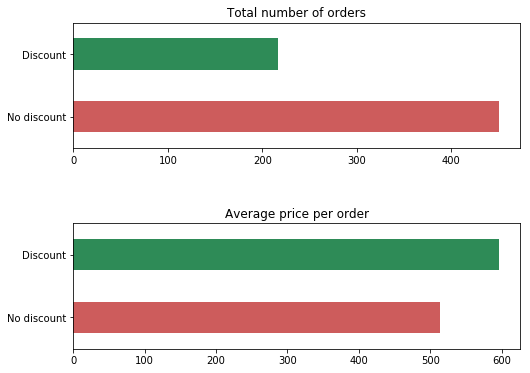

In [72]:
# Plotting the number of orders and average price per order for orders with and without discounts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df2.groupby(['Discount_bin'])['price_per_order'].count().plot(kind='barh', ax=ax1, color=['indianred', 'seagreen'])
df2.groupby(['Discount_bin'])['price_per_order'].mean().plot(kind='barh', ax=ax2, color=['indianred', 'seagreen'])
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax2.set_title('Average price per order')
ax1.set_yticklabels(['No discount', 'Discount'])
ax2.set_yticklabels(['No discount', 'Discount'])
fig.subplots_adjust(hspace=0.6);

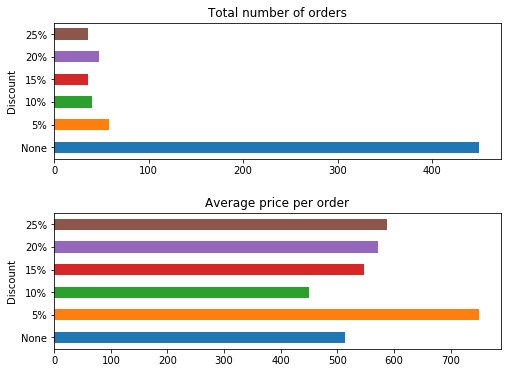

In [71]:
# Plotting the number of orders and average price per order for orders with different levels of discount
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df2.groupby(['Discount'])['price_per_order'].count().plot(kind='barh', ax=ax1)
df2.groupby(['Discount'])['price_per_order'].mean().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('Discount')
ax2.set_ylabel('Discount')
ax2.set_title('Average price per order')
ax1.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
ax2.set_yticklabels(['None', '5%', '10%', '15%', '20%', '25%'])
fig.subplots_adjust(hspace=0.4);

In [100]:
# Average order prices for each discount level
round(df2.groupby(['Discount'])['price_per_order'].mean(),2)

Discount
0.00    513.91
0.05    750.59
0.10    450.47
0.15    547.65
0.20    571.89
0.25    587.61
Name: price_per_order, dtype: float64

In order to test whether there is a statistically significant difference between orders with and without a discount, a two-sample t-test will be used. This test assumes that the data is normally distributed, and that the samples have equal variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


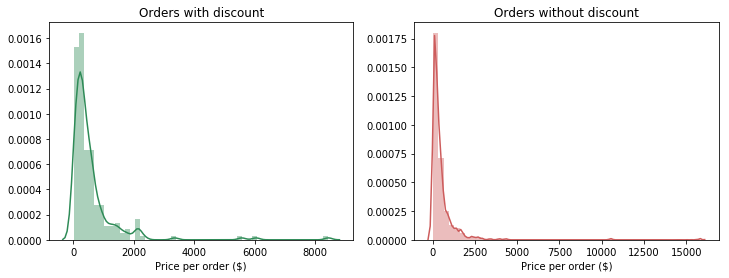

In [86]:
# Separating the dataset into orders with and without discounts, and assessing their distributions
discount = df2[df2['Discount_bin'] == 1]
no_discount = df2[df2['Discount_bin'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(discount.price_per_order, color='seagreen', ax=ax1)
sns.distplot(no_discount.price_per_order, color='indianred', ax=ax2)
plt.title('Distribution plots of the average price per order')
ax1.set_title('Orders with discount')
ax2.set_title('Orders without discount')
ax1.set_xlabel('Price per order ($)')
ax2.set_xlabel('Price per order ($)');

The distribution plots above show that the data is heavily positively skewed, with long tails. Log-transforming the data is likely to make it better fit the t-test assumptions.

In [87]:
# Log-transforming price_per_order
df2_log = df2.copy()
df2_log['price_per_order'] = np.log(df2['price_per_order'])

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


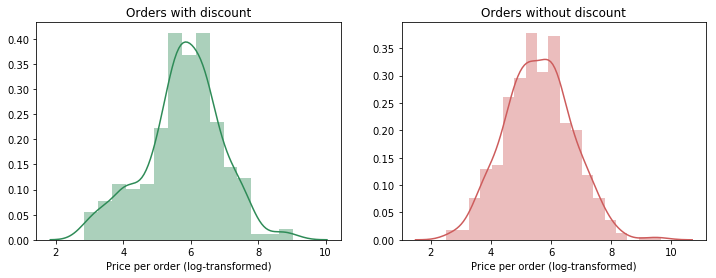

In [88]:
# Re-plotting the distributions for the log-transformed data
discount_log = df2_log[df2_log['Discount_bin'] == 1]
no_discount_log = df2_log[df2_log['Discount_bin'] == 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(discount_log.price_per_order, color='seagreen', ax=ax1)
sns.distplot(no_discount_log.price_per_order, color='indianred', ax=ax2)
plt.title('Distribution plots of the average price per order')
ax1.set_title('Orders with discount')
ax2.set_title('Orders without discount')
ax1.set_xlabel('Price per order (log-transformed)')
ax2.set_xlabel('Price per order (log-transformed)');

The data is now more normally distributed, and the variances from the mean are more similar.

In [89]:
# Running a two-sided t-test to compare two independent samples
stats.ttest_ind(discount_log.price_per_order, no_discount_log.price_per_order)

Ttest_indResult(statistic=2.173240470129464, pvalue=0.030114462592937513)

In [92]:
print("Average price per order for orders with no discounts: ", round(no_discount['price_per_order'].mean(),2))
print("Average price per order for orders with discounts: ", round(discount['price_per_order'].mean(),2))
print("Effect size: ", round(discount['price_per_order'].mean() - no_discount['price_per_order'].mean(),2))
print("Relative effect size (increase from no discount to discount): ", round(((discount['price_per_order'].mean() - no_discount['price_per_order'].mean())/no_discount['price_per_order'].mean())*100,1))

Average price per order for orders with no discounts:  513.91
Average price per order for orders with discounts:  595.86
Effect size:  81.95
Relative effect size (increase from no discount to discount):  15.9


The p-value is 0.030, which is less than our alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternative hypothesis. We can conclude that there is a statistically significant difference between the average price per order for orders with and without discounts, i.e. offering a discount does change (in this case increase) the number of items that a customer orders.

**On average:**

**The average cost per order with no discount is \\$513.91, and the avverage cost per order with a discount is \\$595.86.**

**On average, customers spend $81.95 more on orders with discounts than without discounts, which is a 16% increase.**

**However, these correlations do not necessarily imply causation, and so it is not possible to categorically state that offering a discount will necessarily increase the amount that customers spend on an order by 16%.**

The second part of the question asks at what level of discount the statistically significant effect occurs. To answer this part of this question, a new null and alternate hypothesis need to be created:

**H<sub>0</sub>**: the average price per order is the same at different levels of discount

**H<sub>a</sub>**: the average price per order is different between the different levels of discount

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

To answer this question, ANOVA will be used in order to assess the degree of variation between multiple samples, where each sample is a different level of discount.

In [97]:
# Fitting a model of price_per_order on Discount categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Discount)', discount_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),12.467334,4.0,2.446268,0.047519
Residual,270.112989,212.0,NaN,NaN


In [98]:
# Summary of the model and its coefficients
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_order   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     2.446
Date:                Fri, 08 Mar 2019   Prob (F-statistic):             0.0475
Time:                        13:38:05   Log-Likelihood:                -331.66
No. Observations:                 217   AIC:                             673.3
Df Residuals:                     212   BIC:                             690.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.1692      0.148     41.624      0.000       5.877       6.461
C(Discount)[T.0.1]     -0.5990      0.232     -2.582      0.010      -1.056      -0.142
C(Discount)[T.0.15]    -0.5179      0.239     -2.163      0.032      -0.990      -0.046
C(Discount)[T.0.2]     -0.5426      0.222     -2.449      0.015      -0.979      -0.106
C(Discount)[T.0.25]    -0.4671      0.239     -1.950      0.052      -0.939       0.005
==============================================================================
Omnibus:                        1.871   Durbin-Watson:                   1.953
Prob(Omnibus):                  0.392   Jarque-Bera (JB):                1.534
Skew:                          -0.185   Prob(JB):                        0.464
Kurtosis:                       3.182   Cond. No.                         5.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# Difference between the average price of orders with no discount and with different levels of discount
print("Absolute difference from no discount to 5% discount: ", float(round((df2.loc[df2.Discount == 0.05]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean(),2)))
print("Proportional difference from no discount to 5% discount: ", float(round(((df2.loc[df2.Discount == 0.05]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 10% discount: ", float(round(((df2.loc[df2.Discount == 0.10]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 15% discount: ", float(round(((df2.loc[df2.Discount == 0.15]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 20% discount: ", float(round(((df2.loc[df2.Discount == 0.20]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))
print("Proportional difference from no discount to 25% discount: ", float(round(((df2.loc[df2.Discount == 0.25]).price_per_order.mean() - (df2.loc[df2.Discount == 0]).price_per_order.mean()) / ((df2.loc[df2.Discount == 0]).price_per_order.mean()),2)))

Absolute difference from no discount to 5% discount:  236.69
Proportional difference from no discount to 5% discount:  0.46
Proportional difference from no discount to 10% discount:  -0.12
Proportional difference from no discount to 15% discount:  0.07
Proportional difference from no discount to 20% discount:  0.11
Proportional difference from no discount to 25% discount:  0.14


The ANOVA table above reveals that the p-value is 0.048, which is just below our alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternate hypothesis. **We can conclude that there are significant differences in average order value between different discount levels, i.e. offering different levels of discount has a significant effect on the price per order.**

The model summary also shows that there is a statistically significant difference between a discount level of 5% and discount levels of 10%, 15% and 20%. The p-value for the difference between discount rates of 5% and 25% is borderline (p = 0.052, similar to but slightly above the alpha level of 0.05). This means that the decreases in average order value between orders with a discount of 5% and those with other discount levels are statistically significant. However, the overall r/eta squared value for the model is very low, implying that discount level only explains a small amount of the variation in price per order.

**Business insights:**
 - There are statistically significant differences in the average price per order with different discount levels.
 - The biggest difference is between orders with no discount (average price \\$513.91) and orders with a 5% discount (average price \\$750.59). The difference is \\$236.69, meaning that the average price of an order with a 5% discount is 46% higher than an order with no discount.
 - However, there are diminishing returns from offering higher levels of discount. For example, the average price of an order with a 10% discount (on all products) is actually 12% lower than an order with no discount.
 - The only discount level that earns more than it costs, i.e. results in an average price per order that is higher than the amount of the discount, is 5%.
 - This analysis accords with the results of the answers to the previous question, that 5% is the optimum discount rate.
 
**Potential business actions:**

To increase revenue, one option worth considering would be to offer more 5% discounts, and fewer discounts of higher value. However, further analysis would be needed to confirm that this is the best option, e.g. analysis of the different types of products that make up the different orders, what the existing levels of discount are that are offered on different products, and investigating what other factors influence the average price of an order.

***

## Question 3: Does the average amount spent per order vary between customers from different regions?

### Obtaining and scrubbing the data

In this query, we want to extract for each order the customer region, the number of each product ordered, the unit price and the discount level (for calculating the actual price paid). To do this we need to join the Customer and OrderDetail tables using the Order table. As with question 1, we need to group by OrderId and Discount to allow us to calculate the total cost per order.

In [20]:
# Extracting the dataset for question 2 as a pandas dataframe
df2 = pd.read_sql_query("""SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    GROUP BY od.OrderId, od.Discount
    """, engine)
df2.head()

2019-03-07 18:03:49,082 INFO sqlalchemy.engine.base.Engine SELECT c.Region, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM Customer c
    JOIN [Order] o ON c.Id = o.CustomerId
    JOIN OrderDetail od ON od.OrderId = o.Id
    GROUP BY od.OrderId, od.Discount
    
2019-03-07 18:03:49,084 INFO sqlalchemy.engine.base.Engine ()


,Region,OrderId,Quantity,UnitPrice,Discount
0,Western Europe,10248,5,34.8,0.00
1,Western Europe,10249,40,42.4,0.00
2,South America,10250,10,7.7,0.00
3,South America,10250,15,16.8,0.15
4,Western Europe,10251,20,16.8,0.00


In [21]:
len(df2)

965

In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 5 columns):
Region       965 non-null object
OrderId      965 non-null int64
Quantity     965 non-null int64
UnitPrice    965 non-null float64
Discount     965 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 37.8+ KB


There are no null values, so no need to replace any values.

An additional column will be added to calculate the actual price per order, by applying the discount to the product of the unit price and the unit quantity:

In [23]:
# Calculating the price per sub-order
df2['price_per_order'] = df2.Quantity * df2.UnitPrice * (1 - df2.Discount)

In [24]:
# Dropping the columns for quantity, unit price and discount now that we have the total price
df2.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

In [25]:
# Grouping the data by order and summing the price for each order
df2 = df2.groupby(['Region', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId as we no longer need this
df2.drop('OrderId', axis=1, inplace=True)

In [26]:
df2.head()

,Region,price_per_order
0,British Isles,239.4
1,British Isles,1581.0
2,British Isles,51.6
3,British Isles,360.0
4,British Isles,86.4


In [27]:
len(df2)

801

### Exploring the data and answering the question

#### Does the average amount spent per order vary between customers from different regions?

To answer this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average amount spent per order is the same between different customer regions

**H<sub>a</sub>**: the average amount spent per order is different (either higher or lower) between different customer regions

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

The table below shows the number of orders per region in the dataset:

In [28]:
df2.groupby('Region').count()

,price_per_order
Region,
British Isles,75
Central America,21
Eastern Europe,7
North America,152
Northern Europe,55
Scandinavia,28
South America,127
Southern Europe,64
Western Europe,272


Some regions only have a small number of orders, so it is worth combining them with other groups so that the groups are not of extremely unequal sizes (and therefore potentially also variances, which is relevant for the statistical tests that will be conducted later). A minimum group size of 30 will be used, so that t-tests can be used robustly.

In [29]:
# Combining Eastern and Southern Europe
df2.loc[(df2.Region == 'Eastern Europe') | (df2.Region == 'Southern Europe'),'Region'] = 'Southern and Eastern Europe'
# Combining Scandinavia and Northern Europe
df2.loc[(df2.Region == 'Scandinavia') | (df2.Region == 'Northern Europe'),'Region'] = 'Northern Europe and Scandinavia'
# Combining Central and South America
df2.loc[(df2.Region == 'Central America') | (df2.Region == 'South America'),'Region'] = 'South and Central America'

In [30]:
# Confirming no groups are smaller than 30
df2.groupby('Region').count()

,price_per_order
Region,
British Isles,75
North America,152
Northern Europe and Scandinavia,83
South and Central America,148
Southern and Eastern Europe,71
Western Europe,272


In [31]:
# Inspecting the summary statistics
df2.describe()

,price_per_order
count,801.000000
mean,676.557321
std,1076.465511
min,12.500000
25%,165.200000
50%,368.000000
75%,818.400000
max,15810.000000


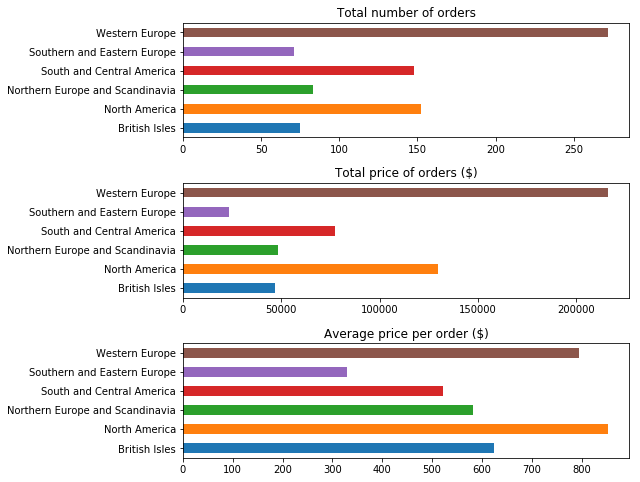

In [32]:
# Plotting the number of orders, total price per order and average price per order for each region
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8,8))
df2.groupby(['Region'])['Region'].count().plot(kind='barh', ax=ax1)
df2.groupby(['Region'])['price_per_order'].sum().plot(kind='barh', ax=ax2)
df2.groupby(['Region'])['price_per_order'].mean().plot(kind='barh', ax=ax3)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Total price of orders ($)')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax3.set_title('Average price per order ($)')
fig.subplots_adjust(hspace=0.4);

In [33]:
# Total number of orders
df2.groupby(['Region'])['Region'].count()

Region
British Isles                       75
North America                      152
Northern Europe and Scandinavia     83
South and Central America          148
Southern and Eastern Europe         71
Western Europe                     272
Name: Region, dtype: int64

In [34]:
# Total price of orders
round(df2.groupby(['Region'])['price_per_order'].sum(),2)

Region
British Isles                       46884.86
North America                      129700.16
Northern Europe and Scandinavia     48310.29
South and Central America           77367.82
Southern and Eastern Europe         23387.12
Western Europe                     216272.18
Name: price_per_order, dtype: float64

In [35]:
# Average price of orders
round(df2.groupby(['Region'])['price_per_order'].mean(),2)

Region
British Isles                      625.13
North America                      853.29
Northern Europe and Scandinavia    582.05
South and Central America          522.76
Southern and Eastern Europe        329.40
Western Europe                     795.12
Name: price_per_order, dtype: float64

The graphs and tables above show that Western Europe is the region with the greatest number of orders, and also has the greatest total price of orders. However, North America has the most expensive order on average, followed by Western Europe. Southern and Eastern Europe has the smallest number of orders, lowest total price of orders, and cheapest order on average. The third graph lends support to the alternate hypothesis that there are significant differences in average order price between regions. This can be further investigated with statistical hypothesis testing.

In this case, ANOVA will be used to test whether the differences between multiple samples (each region) are statistically significant.

ANOVA assumes that the data is normally distributed, and that the samples have similar variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


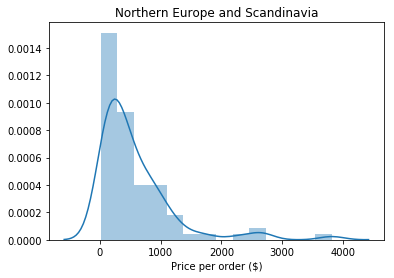

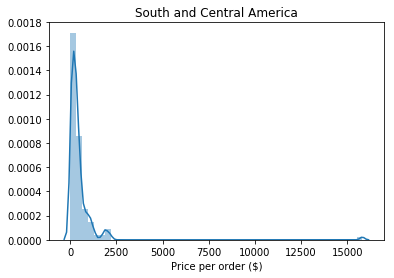

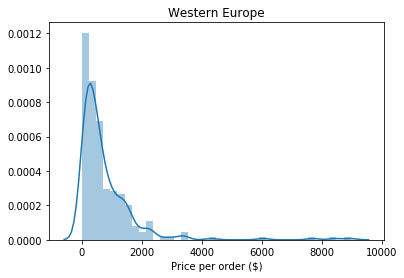

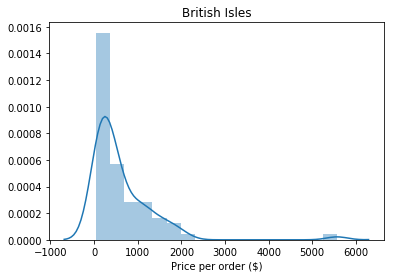

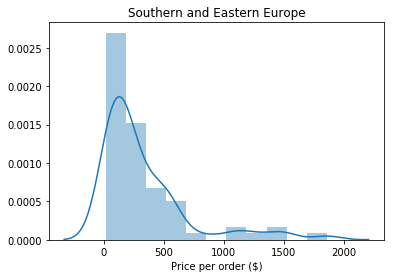

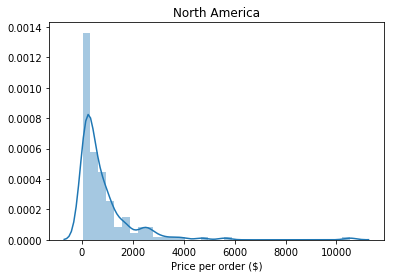

In [36]:
# Separating the dataset into orders from different regions, and assessing their distributions
for region in set(df2.Region):
    region_group = df2.loc[df2['Region'] == region]
    sns.distplot(region_group['price_per_order'])
    plt.title(region)
    plt.xlabel('Price per order ($)')
    plt.show()

The distribution plots above show that the data is heavily positively skewed, with very long tails (of different lengths for different regions). Although ANOVA is relatively robust to non-normal distributions, log-transforming the data is likely to make it better fit the ANOVA assumptions.

In [37]:
# Log-transforming price_per_order
df2_log = df2.copy()
df2_log['price_per_order'] = np.log(df2['price_per_order'])

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


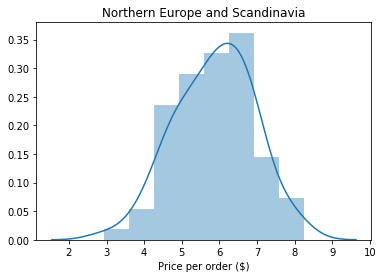

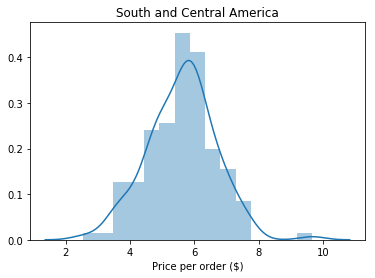

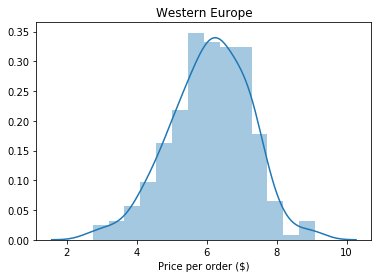

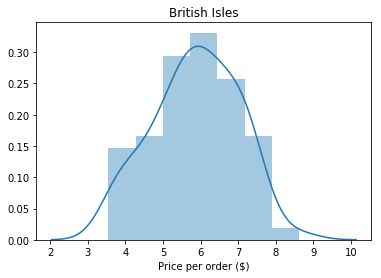

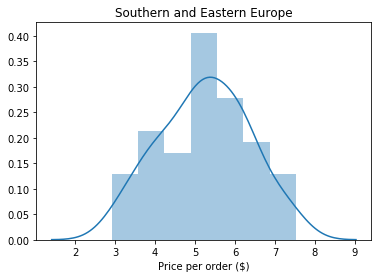

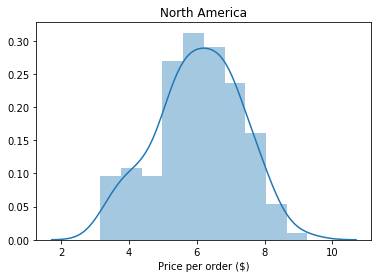

In [38]:
# Re-plotting the distributions for the log-transformed data
for region in set(df2_log.Region):
    region_group = df2_log.loc[df2_log['Region'] == region]
    sns.distplot(region_group['price_per_order'])
    plt.title(region)
    plt.xlabel('Price per order ($)')
    plt.show()

The data is now more normally distributed, and the variances from the mean are more similar. It is now possible to run an ANOVA test.

In [39]:
# Fitting a model of price_per_order on Region categories, and using statsmodels to compute an ANOVA table
lm = ols('price_per_order ~ C(Region)', df2_log).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Region),56.792498,5.0,8.831864,3.597830e-08
Residual,1022.435026,795.0,NaN,NaN


In [40]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        price_per_order   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     8.832
Date:                Thu, 07 Mar 2019   Prob (F-statistic):           3.60e-08
Time:                        18:03:53   Log-Likelihood:                -1234.3
No. Observations:                 801   AIC:                             2481.
Df Residuals:                     795   BIC:                             2509.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        5.8670      0.131     44.803      0.000       5.610       6.124
C(Region)[T.North America]                       0.1774      0.160      1.108      0.268      -0.137       0.491
C(Region)[T.Northern Europe and Scandinavia]     0.0010      0.181      0.006      0.995      -0.354       0.356
C(Region)[T.South and Central America]          -0.2621      0.161     -1.631      0.103      -0.578       0.053
C(Region)[T.Southern and Eastern Europe]        -0.6311      0.188     -3.361      0.001      -1.000      -0.262
C(Region)[T.Western Europe]                      0.2235      0.148      1.511      0.131      -0.067       0.514
==============================================================================
Omnibus:                        3.771   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                3.755
Skew:                          -0.168   Prob(JB):                        0.153
Kurtosis:                       2.988   Cond. No.                         9.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
# Difference between the average price of orders from Southern and Eastern European customers to those from North American customers
print("Absolute difference: ", float(round((df2.loc[df2.Region == 'North America']).mean() - (df2.loc[df2.Region == 'Southern and Eastern Europe']).mean(),2)))
print("Proportional difference: ", float(round(1 + ((df2.loc[df2.Region == 'North America']).mean() - (df2.loc[df2.Region == 'Southern and Eastern Europe']).mean()) / ((df2.loc[df2.Region == 'Southern and Eastern Europe']).mean()),2)))

Absolute difference:  523.89
Proportional difference:  2.59


In [42]:
# Increase from the average price of orders from South and Central American customers to those from North American customers
1 + ((df2.loc[df2.Region == 'North America']).mean() - (df2.loc[df2.Region == 'South and Central America']).mean()) / ((df2.loc[df2.Region == 'South and Central America']).mean())

price_per_order    1.632294
dtype: float64

The ANOVA table above reveals that the p-value is  lower than the alpha value of 0.05. Therefore we can reject the null hypothesis and accept the alternate hypothesis. **We can conclude that there are significant differences in average order value between different regions, i.e. customers from different parts of the world spend different amounts of money on their orders, on average.**

**Business insights:** 
 - There are statistically significant differences in the average price per order from customers from different regions.
 - Western Eurpean customers place the most orders, and are the single biggest contributors to Northwind's bottom line. However, although North American customers have placed roughly half as many orders as those from Western Europe, they spend more per order, on average.
  - The difference between the region with the most expensive orders on average (North America, \\$853.29) and the region with the least expensive orders (Southern and Eastern Europe, \\$329.40) is \\$523.89, or 2.6 times more.
  - Southern and Eastern Europe has the smallest number of orders, the lowest total price of orders, and the lowest average price per order.
 - North American customers have placed a similar number of orders to those from South and Central America, but their average expenditure per order is 1.6 times higher.


**Potential business actions:**

If Northwind was looking to focus on more profitable customers, a potential action would be to stop serving customers in Southern and Eastern Europe, and to focus more on customers in Western Europe and North America. However, further analysis would be needed to confirm these findings (for example, it might be the case that some more expensive products are only available in certain regions).

***

## Question 3: Are differences in the numbers of different types of product that customers order statistically significant? If so, what is the most popular product category?

### Obtaining and scrubbing the data

In this query, we want to extract the number of products in each order that fall into each product category. To do this we need to join the Category and Order tables via the Product table. We need to group by OrderId because we are interested in the number of products of each category per order.

In [43]:
df3 = pd.read_sql_query("""SELECT c.CategoryName, od.Quantity
    FROM Category c
    JOIN Product p on p.CategoryId = c.Id
    JOIN OrderDetail od on od.ProductId = p.Id
    GROUP BY od.OrderId
    """, engine)
df3.head()

2019-03-07 18:03:53,861 INFO sqlalchemy.engine.base.Engine SELECT c.CategoryName, od.Quantity
    FROM Category c
    JOIN Product p on p.CategoryId = c.Id
    JOIN OrderDetail od on od.ProductId = p.Id
    GROUP BY od.OrderId
    
2019-03-07 18:03:53,864 INFO sqlalchemy.engine.base.Engine ()


,CategoryName,Quantity
0,Dairy Products,5
1,Produce,40
2,Condiments,15
3,Condiments,20
4,Dairy Products,40


In [44]:
len(df3)

830

In [45]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
CategoryName    830 non-null object
Quantity        830 non-null int64
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


There are no null values, so no need to replace any values.

### Exploring the data and answering the question

#### Are differences in the numbers of different types of product that customers order statistically significant? If so, what is the most popular product category?

To answer the first part of question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the 

**H<sub>a</sub>**: the 

This question will be answered using data from the Customers and OrderDetail tables, which includes data on [...], and is stored in df2.

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [46]:
df3.groupby('CategoryName').count()

,Quantity
CategoryName,
Beverages,171
Condiments,98
Confections,100
Dairy Products,176
Grains/Cereals,94
Meat/Poultry,56
Produce,38
Seafood,97


In [47]:
# Inspecting the summary statistics
df3.describe()

,Quantity
count,830.000000
mean,22.883133
std,18.952727
min,1.000000
25%,10.000000
50%,20.000000
75%,30.000000
max,130.000000


***

## Question 4: Do customers order more products on particular days of the week?

### Obtaining and scrubbing the data

In this query, we want to extract the date that each order was placed on, the number of each product ordered, the unit price and the discount level (for calculating the actual price paid). To do this we need to join the Order and OrderDetail tables. As with question 1, we need to group by OrderId and Discount to allow us to calculate the total cost per order.

In [48]:
# Extracting the dataset for question 4 as a pandas dataframe
df4 = pd.read_sql_query("""SELECT o.OrderDate, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM [Order] o
    JOIN OrderDetail od ON od.OrderId = o.Id
    GROUP BY od.OrderId, od.Discount
    """, engine)
df4.head()

2019-03-07 18:03:53,945 INFO sqlalchemy.engine.base.Engine SELECT o.OrderDate, od.OrderId, od.Quantity, od.UnitPrice, od.Discount
    FROM [Order] o
    JOIN OrderDetail od ON od.OrderId = o.Id
    GROUP BY od.OrderId, od.Discount
    
2019-03-07 18:03:53,946 INFO sqlalchemy.engine.base.Engine ()


,OrderDate,OrderId,Quantity,UnitPrice,Discount
0,2012-07-04,10248,5,34.8,0.00
1,2012-07-05,10249,40,42.4,0.00
2,2012-07-08,10250,10,7.7,0.00
3,2012-07-08,10250,15,16.8,0.15
4,2012-07-08,10251,20,16.8,0.00


In [49]:
len(df4)

1000

An additional column will be added to calculate the actual price per order, by applying the discount to the product of the unit price and the unit quantity:

In [50]:
# Calculating the price per sub-order
df4['price_per_order'] = df4.Quantity * df4.UnitPrice * (1 - df4.Discount)

In [51]:
# Dropping the columns for quantity, unit price and discount now that we have the total price
df4.drop(['Quantity', 'UnitPrice', 'Discount'], axis=1, inplace=True)

In [52]:
# Grouping the data by date and summing the price for each order
df4 = df4.groupby(['OrderDate', 'OrderId'])['price_per_order'].sum().reset_index()
# Dropping the OrderId as we no longer need this
df4.drop('OrderId', axis=1, inplace=True)

In [53]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 2 columns):
OrderDate          830 non-null object
price_per_order    830 non-null float64
dtypes: float64(1), object(1)
memory usage: 13.0+ KB


Now we need to convert OrderDate to the day of the week.

In [54]:
# Converting to datetime
df4['OrderDate'] = pd.to_datetime(df4['OrderDate'])
# Adding a column for the day of the week
df4['day_of_week'] = df4['OrderDate'].dt.weekday_name
# Adding a column for the number of the day of the week (to help with visualising in the correct order)
df4['int_day_of_week'] = df4['OrderDate'].dt.dayofweek

In [55]:
df4.head()

,OrderDate,price_per_order,day_of_week,int_day_of_week
0,2012-07-04,174.0,Wednesday,2
1,2012-07-05,1696.0,Thursday,3
2,2012-07-08,291.2,Sunday,6
3,2012-07-08,558.3,Sunday,6
4,2012-07-09,1135.5,Monday,0


### Exploring the data and answering the question

#### Do customers order more products on particular days of the week?

To answer this question, a null and alternate hypothesis first need to be created:

**H<sub>0</sub>**: the average amount spent on each day of the week is the same for each day

**H<sub>a</sub>**: the average amount spent on each day of the week is different (either higher or lower) for each day

The alpha level (i.e. the probability of rejecting the null hypothesis when it is true) will be set at 0.05.

In [56]:
# Investigating date range
print(f"The dates range from {df4.OrderDate.min().date()} to {df4.OrderDate.max().date()}")

The dates range from 2012-07-04 to 2014-05-06


In [57]:
# Plotting the number of orders per month


In [58]:
df4.groupby(['day_of_week'])['day_of_week'].count()

day_of_week
Monday       168
Sunday       165
Thursday     164
Tuesday      165
Wednesday    168
Name: day_of_week, dtype: int64

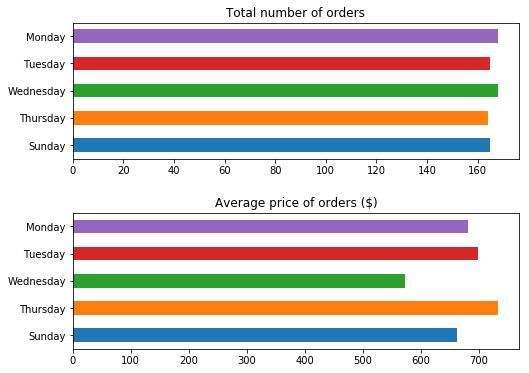

In [59]:
# Plotting the number of orders average price per order by day of the week
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
df4.sort_values(['int_day_of_week'], ascending=False).groupby(['day_of_week'], sort=False)['day_of_week'].count().plot(kind='barh', ax=ax1)
df4.sort_values(['int_day_of_week'], ascending=False).groupby(['day_of_week'], sort=False)['price_per_order'].mean().plot(kind='barh', ax=ax2)
ax1.set_title('Total number of orders')
ax1.set_ylabel('')
ax2.set_title('Average price of orders ($)')
ax2.set_ylabel('')
fig.subplots_adjust(hspace=0.4);

The graphs above demonstrate that there are almost identical numbers of orders made on each day of the week (Sunday-Thursday, as there are no orders made on Friday or Saturday in the dataset). However, there are differences in the average price of orders made on each day. Whether or not these differences are statistically signicant will be tested below, using ANOVA.

ANOVA assumes that the data is normally distributed, and that the samples have similar variances. This can be assessed with distribution plots:

C:\Users\Laura\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


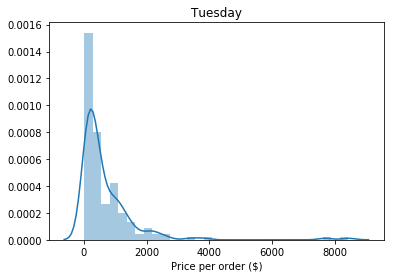

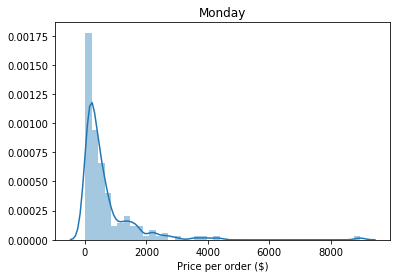

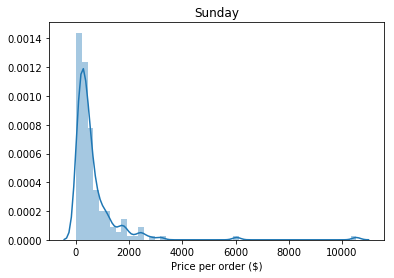

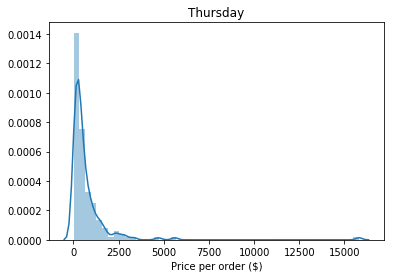

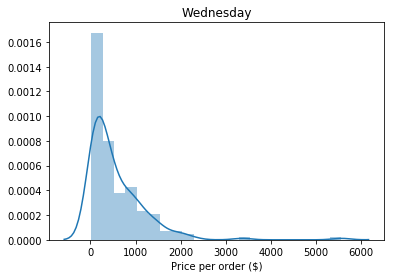

In [63]:
# Separating the dataset into orders from different days, and assessing their distributions
for day in set(df4['day_of_week']):
    day_group = df4.loc[df4['day_of_week'] == day]
    sns.distplot(day_group['price_per_order'])
    plt.title(day)
    plt.xlabel('Price per order ($)')
    plt.show()

Log-transform